## Plot random example of car and non-car objects from the dataset

/Users/mimihoang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


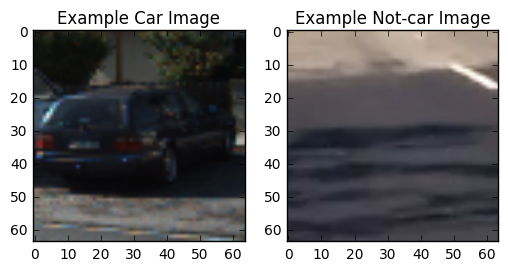

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

%matplotlib inline  

# Read in our vehicles and non-vehicles
cars = glob.glob('vehicles/*/*')
notcars = glob.glob('non-vehicles/*/*')

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [2]:
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
    
# Compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    #print('size', size)
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extract features from a single image
def extract_single_image_features(image, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    # Apply bin_spatial() to get spatial color features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
        
    # Apply color_hist() also with a color space option now
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == -1:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
  
    return np.concatenate(features)


# Extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_list = extract_single_image_features(image, cspace=cspace, spatial_size=spatial_size,
                    hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

        # Append the new feature vector to the features list
        features.append(feature_list)
    # Return list of feature vectors
    return features


## Normalize extracted features and randomize selection for training and testing

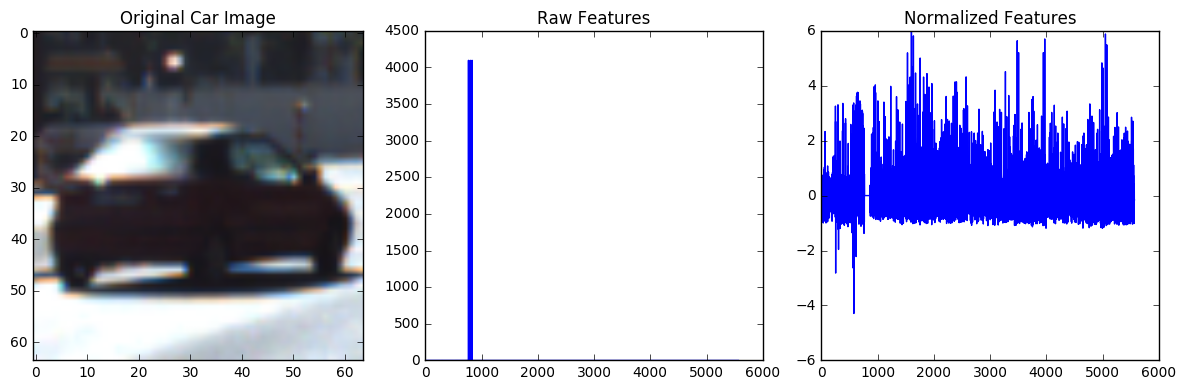

In [4]:
spatial = 16
histbin = 32
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = -1 # -1="All" or 0, 1, 2
color_space = 'YCrCb'

car_features = extract_features(cars, cspace=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


X = np.vstack((car_features, notcar_features)).astype(np.float64)
                
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Car Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


## Train a classifier Linear SVM classifier

In [5]:
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
print('Total training images:', len(X_train))
print('Total test images:', len(X_test))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 5568
Total training images: 14208
Total test images: 3552
12.92 Seconds to train SVC
Test Accuracy of SVC =  0.9882


## Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

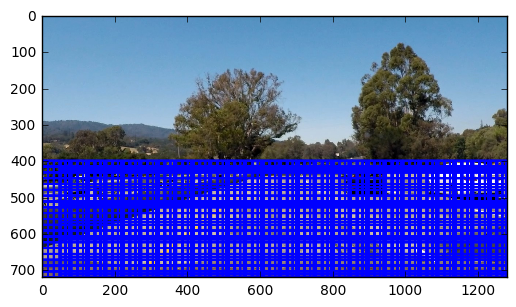

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[50, None], y_start_stop=[400, 700], 
                       xy_window=(96, 96), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Implement a sliding-window technique and use the trained classifier to search for vehicles in images

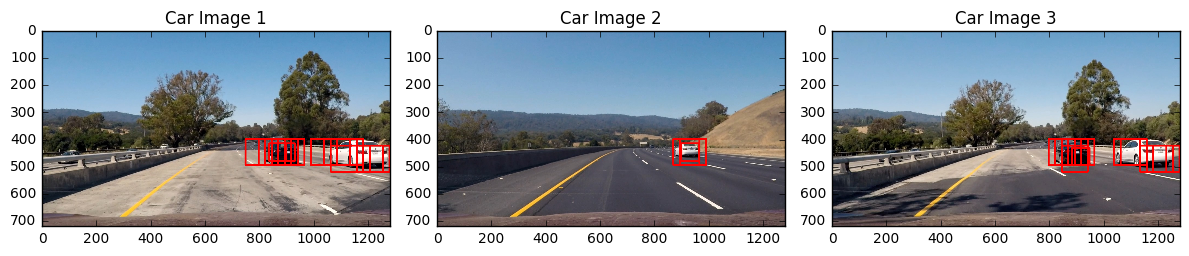

In [36]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):
    

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        #print(test_img.shape)
        #4) Extract features for that window using single_img_features()
        features = extract_single_image_features(test_img, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        dec = svc.decision_function(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1 and dec > .8:
            #print (prediction, dec)
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def process_image(image, video=True):
    # Save a raw image
    draw_image = np.copy(image)
    # Normalize image
    image = image.astype(np.float32)/255
    # Apply pipeline to the image to create black and white image
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=(spatial, spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel) 
    # # Combine overlapping windows
    draw_image = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)
    
    if not video:
        return draw_image, hot_windows
    else:
        return draw_image

images = []
for i in range(1,5):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
    draw_image, _ = process_image(image, False)
    images.append(draw_image)
    
    
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(images[0])
plt.title('Car Image 1')
plt.subplot(132)
plt.imshow(images[2])
plt.title('Car Image 2')
plt.subplot(133)
plt.imshow(images[3])
plt.title('Car Image 3')
fig.tight_layout()


## Estimate a bounding box for vehicles detected

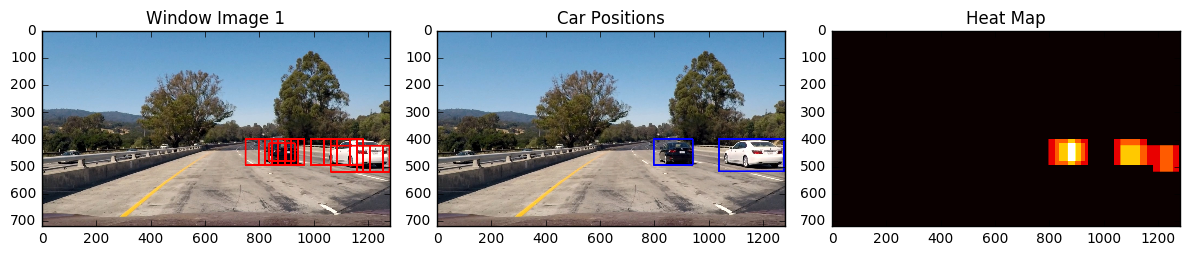

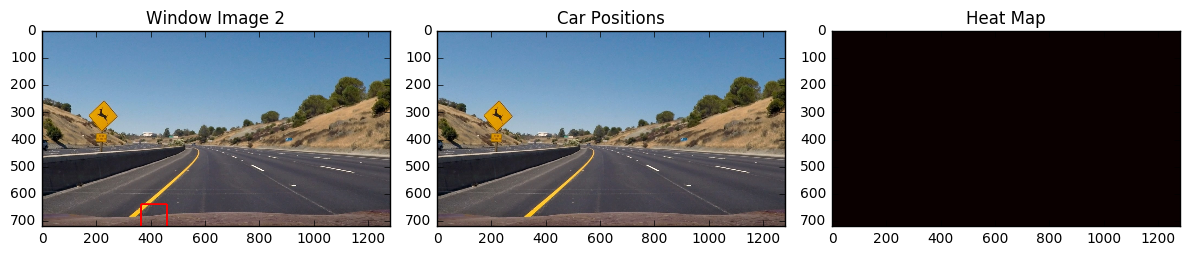

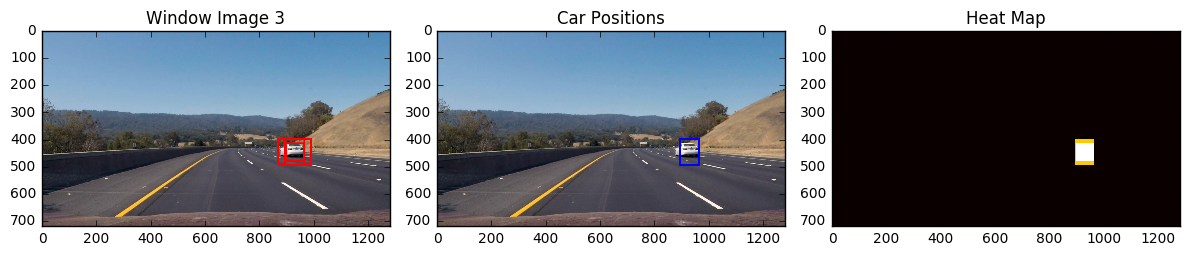

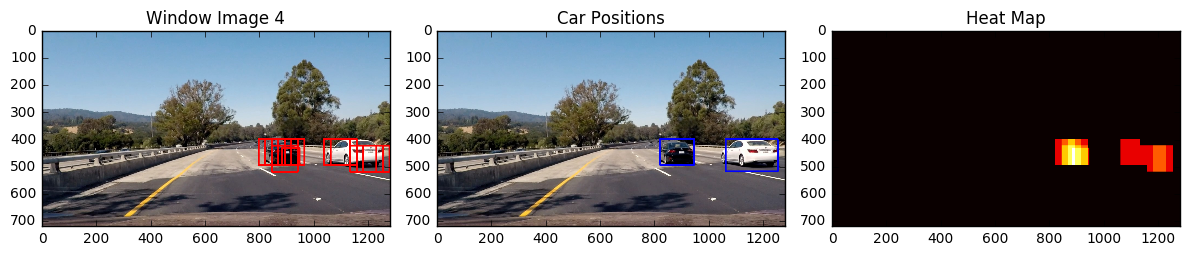

In [98]:
import scipy.misc
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def create_heat_map(image, combine_frame_no=0, threshold=2, combine_frame=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Use this when process video frames
    if combine_frame:
        for boxlist in all_bboxes[-combine_frame_no:]:
            heat = add_heat(heat, boxlist)
    else:
        heat = add_heat(heat, all_bboxes[-1])
        

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap
    


def process_image_with_heatmap(image, all_bboxes,frame_no, combine_frame_no=5, threshold=4): 

    window_img, hot_windows = process_image(image, False)
    #scipy.misc.imsave('window_image/frame' + str(frame) + '.jpg', window_img)
    
    all_bboxes.append(hot_windows)
    
    # Adjust parameters if needed
    if len(all_bboxes) < frame_no:
        combine_frame_no = frame_no    
        
    draw_img, heat_map = create_heat_map(image, combine_frame_no=combine_frame_no, threshold=threshold, combine_frame=True)
    
    return draw_img




for i in range(1,5):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
    window_img, hot_windows = process_image(image, False)
    all_bboxes.append(hot_windows)
    draw_img, heatmap = create_heat_map(image, threshold=1)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Window Image ' + str(i))
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()



## Run pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles

In [96]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy.misc

frame = 1
all_bboxes = []

def pipeline(image):
    global frame
    global all_bboxes 

    output_image = process_image_with_heatmap(image, all_bboxes, frame)
    #scipy.misc.imsave('video_output_images1/frame' + str(frame) + '.jpg', output_image)
    frame +=1
    return output_image

video = VideoFileClip("project_video.mp4")
video_output = "project_video_solution.mp4"
white_clip = video.fl_image(pipeline) 
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4



100%|█████████▉| 1260/1261 [1:50:31<00:05,  5.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 1h 49min 50s, sys: 28.9 s, total: 1h 50min 18s
Wall time: 1h 50min 32s
